C:\Users\waste\AppData\Local\Temp\ipykernel_7992\1809068018.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sps = fin.loc['Total Revenue'][0] / info['sharesOutstanding']



[적정주가 계산 결과]
PER: 313.51
PBR: nan
PSR: 319.95
PCR: nan
PEG: -1.24
DCF: 0.00
DDM: 0.00
EV/EBITDA: nan
RIM: nan
자산기반: nan

현재가: 313.51
역대 최고가: 488.54
역대 최저가: 1.00


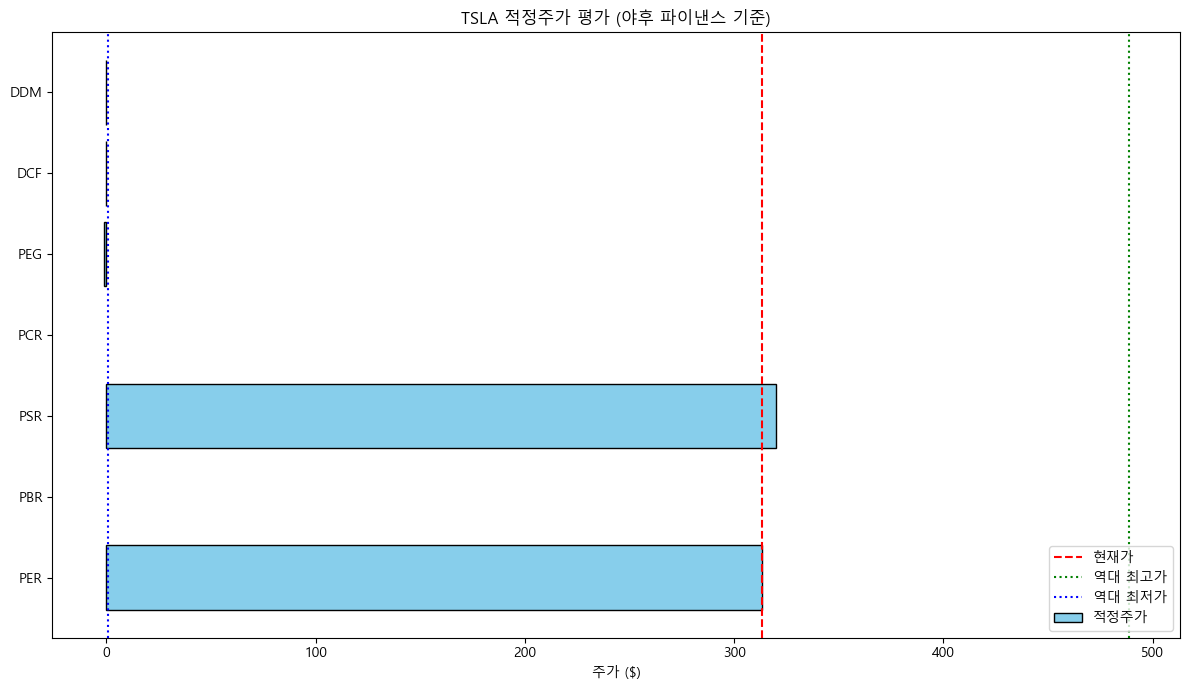

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥
# plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스/윈도우(설치 필요)

plt.rcParams['axes.unicode_minus'] = False  # 마이너스(-) 깨짐 방지


# 적정주가 계산 함수들
def fair_price_per(eps, per):
    return eps * per

def fair_price_pbr(bps, pbr):
    return bps * pbr

def fair_price_psr(sps, psr):
    return sps * psr

def fair_price_pcr(cfps, pcr):
    return cfps * pcr

def fair_price_peg(eps, growth, peg=1):
    if growth == 0:
        return np.nan
    return eps * (peg * growth)

def dcf_valuation(fcf_list, wacc, terminal_growth, shares):
    n = len(fcf_list)
    pv_fcf = sum([fcf / (1 + wacc) ** (i+1) for i, fcf in enumerate(fcf_list)])
    terminal_value = (fcf_list[-1] * (1 + terminal_growth)) / (wacc - terminal_growth)
    pv_terminal = terminal_value / (1 + wacc) ** n
    return (pv_fcf + pv_terminal) / shares

def dividend_discount_model(dividend, growth, required_return):
    if required_return <= growth:
        return np.nan
    return dividend * (1 + growth) / (required_return - growth)

def fair_price_ev_ebitda(ev_ebitda, ebitda, debt, cash, shares):
    enterprise_value = ev_ebitda * ebitda
    equity_value = enterprise_value - debt + cash
    return equity_value / shares

def fair_price_rim(equity, roe, cost_of_equity, shares, years=5):
    residuals = []
    for t in range(1, years+1):
        residual = equity * ((roe - cost_of_equity) / ((1 + cost_of_equity) ** t))
        residuals.append(residual)
    return (equity + sum(residuals)) / shares

def fair_price_asset_based(total_assets, total_liabilities, shares):
    return (total_assets - total_liabilities) / shares

# 데이터 수집 및 계산
def get_stock_data(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    # 재무제표
    fin = stock.financials
    bal = stock.balance_sheet
    cashflow = stock.cashflow

    # 기본 지표
    try:
        eps = info['trailingEps']
    except:
        eps = np.nan
    try:
        per = info['trailingPE']
    except:
        per = np.nan
    try:
        bps = bal.loc['Total Stockholder Equity'][0] / info['sharesOutstanding']
    except:
        bps = np.nan
    try:
        pbr = info['priceToBook']
    except:
        pbr = np.nan
    try:
        sps = fin.loc['Total Revenue'][0] / info['sharesOutstanding']
    except:
        sps = np.nan
    try:
        psr = info['priceToSalesTrailing12Months']
    except:
        psr = np.nan
    try:
        cfps = cashflow.loc['Total Cash From Operating Activities'][0] / info['sharesOutstanding']
    except:
        cfps = np.nan
    try:
        pcr = info['currentPrice'] / cfps if cfps else np.nan
    except:
        pcr = np.nan
    try:
        dividend = info['dividendRate']
    except:
        dividend = 0
    try:
        growth = info['earningsQuarterlyGrowth']
    except:
        growth = 0.05
    try:
        shares = info['sharesOutstanding']
    except:
        shares = 1
    try:
        debt = bal.loc['Total Debt'].iloc[0]
    except:
        debt = 0
    try:
        cash = bal.loc['Cash'][0]
    except:
        cash = 0
    try:
        ebitda = fin.loc['Ebitda'][0]
    except:
        ebitda = np.nan
    try:
        ev_ebitda = info.get('enterpriseToEbitda', np.nan)
    except:
        ev_ebitda = np.nan
    try:
        roe = info.get('returnOnEquity', 0.15)
    except:
        roe = 0.15
    try:
        total_assets = bal.loc['Total Assets'].iloc[0]
    except:
        total_assets = np.nan
    try:
        total_liabilities = bal.loc['Total Liab'][0]
    except:
        total_liabilities = np.nan

    # DCF: 최근 5년 FCF
    try:
        fcf_list = [cashflow.loc['Total Cash From Operating Activities'][i] - cashflow.loc['Capital Expenditures'][i] for i in range(5)]
    except:
        fcf_list = [0] * 5

    # 현재가, 최고/최저가
    hist = stock.history(period="max")
    current_price = hist['Close'].iloc[-1]
    all_time_high = hist['High'].max()
    all_time_low = hist['Low'].min()

    # WACC, 할인율, 성장률, 자본비용(임의값)
    wacc = 0.09
    terminal_growth = 0.03
    required_return = 0.09
    cost_of_equity = 0.09

    return {
        'eps': eps,
        'per': per,
        'bps': bps,
        'pbr': pbr,
        'sps': sps,
        'psr': psr,
        'cfps': cfps,
        'pcr': pcr,
        'dividend': dividend,
        'growth': growth,
        'shares': shares,
        'debt': debt,
        'cash': cash,
        'ebitda': ebitda,
        'ev_ebitda': ev_ebitda,
        'roe': roe,
        'total_assets': total_assets,
        'total_liabilities': total_liabilities,
        'fcf_list': fcf_list,
        'wacc': wacc,
        'terminal_growth': terminal_growth,
        'required_return': required_return,
        'cost_of_equity': cost_of_equity,
        'current_price': current_price,
        'all_time_high': all_time_high,
        'all_time_low': all_time_low
    }

def main():
    ticker = input("종목 티커를 입력하세요 (예: AAPL, MSFT, TSLA): ").strip().upper()
    data = get_stock_data(ticker)

    fair_prices = {}

    fair_prices['PER'] = fair_price_per(data['eps'], data['per'])
    fair_prices['PBR'] = fair_price_pbr(data['bps'], data['pbr'])
    fair_prices['PSR'] = fair_price_psr(data['sps'], data['psr'])
    fair_prices['PCR'] = fair_price_pcr(data['cfps'], data['pcr'])
    fair_prices['PEG'] = fair_price_peg(data['eps'], data['growth'])
    fair_prices['DCF'] = dcf_valuation(data['fcf_list'], data['wacc'], data['terminal_growth'], data['shares'])
    fair_prices['DDM'] = dividend_discount_model(data['dividend'], data['growth'], data['required_return'])
    fair_prices['EV/EBITDA'] = fair_price_ev_ebitda(data['ev_ebitda'], data['ebitda'], data['debt'], data['cash'], data['shares'])
    fair_prices['RIM'] = fair_price_rim(data['bps'] * data['shares'], data['roe'], data['cost_of_equity'], data['shares'])
    fair_prices['자산기반'] = fair_price_asset_based(data['total_assets'], data['total_liabilities'], data['shares'])

    # 결과 출력
    print("\n[적정주가 계산 결과]")
    for method, price in fair_prices.items():
        print(f"{method}: {price:,.2f}")

    print(f"\n현재가: {data['current_price']:.2f}")
    print(f"역대 최고가: {data['all_time_high']:.2f}")
    print(f"역대 최저가: {data['all_time_low']:.2f}")

    # 그래프
    methods = list(fair_prices.keys())
    prices = [fair_prices[m] for m in methods]

    plt.figure(figsize=(12, 7))
    plt.barh(methods, prices, color='skyblue', edgecolor='k', label='적정주가')
    plt.axvline(data['current_price'], color='r', linestyle='--', label='현재가')
    plt.axvline(data['all_time_high'], color='g', linestyle=':', label='역대 최고가')
    plt.axvline(data['all_time_low'], color='b', linestyle=':', label='역대 최저가')
    plt.xlabel('주가 ($)')
    plt.title(f"{ticker} 적정주가 평가 (야후 파이낸스 기준)")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
